In [ ]:
# Source: Financial Modeling Prep
# API key: REMOVED

# Steps:
#   1. get stock symbol list
#   2. for each symbol
#     2.1 get ratios
#   3. Create pd dataframe

# Ratio from study => api calls:
# NOTE: query for 'quarterly', not 'annual'; annual vals have 'TTM' (Trailing 12 Months), while qtrly do not

#   date => "date" from "/enterprise-values/[SYMBOL]?period=quarter[&limit=130]"
#   book value => get balance sheet from "/balance-sheet-statement/[SYMBOL]?period=quarter[&limit=400]"
#     "totalAssets" - ("goodwillAndIntangibleAssets" + "totalLiabilities")
#   market cap => "marketCapitalization" from "/enterprise-values/[SYMBOL]?period=quarter[&limit=130]"
#   dividend yield => "dividendYield" from "/ratios/[SYMBOL]?period=quarter[&limit=140]"
#   best EPS (earnings per share) => from income statement
#   price/earnings ratio => "priceEarningsRatio" from "/ratios/[SYMBOL]?period=quarter[&limit=140]"
#   price to book ratio => "priceToBookRatio" from "/ratios/[SYMBOL]?period=quarter[&limit=140]"
#   DPS (dividends per share) => TODO
#   current ratio => "currentRatio" from "/ratios/[SYMBOL]?period=quarter[&limit=140]"
#   quick ratio => "quickRatio" from "/ratios/[SYMBOL]?period=quarter[&limit=140]"

# api calls referenced above:
#   "/enterprise-values/[SYMBOL]?period=quarter[&limit=130]"
#   "/balance-sheet-statement/[SYMBOL]?period=quarter[&limit=400]"
#   "/ratios/[SYMBOL]?period=quarter[&limit=140]"

In [ ]:
import pandas as pd
import requests
import time

In [ ]:
base_url = "https://financialmodelingprep.com/api/v3"
api_key = "apikey=REMOVED"  # NOTE: preceed with ? or & as appropriate, based on the rest of the url

# Queries will be formulated as:
# base_url + "/[query]" + "[$ or &]" + api_keys

In [ ]:
# 1. Get stock symbol list

res_nasdaq = requests.get(base_url + "/nasdaq_constituent?" + api_key).json()

In [ ]:
NASDAQ100_symbols = []

for row in res_nasdaq:
  NASDAQ100_symbols.append(row["symbol"])

In [ ]:
# Get ratios for each symbol

# example: AAPL

# Init dict
d = {"symbol":[],
     "date":[],
     "bookValue":[],
     "marketCap":[],
     "dividendYield":[],
     "peRatio":[],
     "pbRatio":[],
     "currentRatio":[],
     "quickRatio":[],
     "stockPrice":[],
     "eps":[]
}


for sy in NASDAQ100_symbols:
  # Begin iteration for a symbol
  print(sy + ": ", end="")

  # Get the 4 financial documents
  raw_ent = requests.get(base_url + "/enterprise-values/" + sy + "?period=quarter&" + api_key)
  time.sleep(0.2)
  raw_bal = requests.get(base_url + "/balance-sheet-statement/" + sy + "?period=quarter&" + api_key)
  time.sleep(0.2)
  raw_inc = requests.get(base_url + "/income-statement/" + sy + "?period=quarter&" + api_key)
  time.sleep(0.2)
  raw_rto = requests.get(base_url + "/ratios/" + sy + "?period=quarter&" + api_key)
  time.sleep(0.2)

  # Check status code, confirming all documents received successfully
  if raw_ent.status_code == raw_bal.status_code == raw_inc.status_code == raw_rto.status_code:
    print("All status codes are good. ", end="")
  else:
    print("Status Code FAILED. Skipping...")
    continue

  # Compile dict of all available dates across all 4 documents
  res_ent_list = raw_ent.json()
  res_bal_list = raw_bal.json()
  res_inc_list = raw_inc.json()
  res_rto_list = raw_rto.json()

  # keys: dates
  # vals: list containing financial document rows of that date
  dates = {}

  for row in res_ent_list:
    date = row["date"]
    if not date in dates:
      dates[date] = {"ent":[row],"bal":[],"inc":[],"rto":[]}
    else:
      dates[date]["ent"].append(row)

  for row in res_bal_list:
    date = row["date"]
    if not date in dates:
      dates[date] = {"ent":[],"bal":[row],"inc":[],"rto":[]}
    else:
      dates[date]["bal"].append(row)

  for row in res_inc_list:
    date = row["date"]
    if not date in dates:
      dates[date] = {"ent":[],"bal":[],"inc":[row],"rto":[]}
    else:
      dates[date]["inc"].append(row)

  for row in res_rto_list:
    date = row["date"]
    if not date in dates:
      dates[date] = {"ent":[],"bal":[],"inc":[],"rto":[row]}
    else:
      dates[date]["rto"].append(row)

  # Now, all financial documents available for each date is stored
  # We now extract what data is possible given the docs available FOR each date

  total_written = 0
  for date in dates.keys():
    total_written += 1

    # Do not require financial docs
    d["symbol"].append(sy)
    d["date"].append(date)

    # Requires ENT:
    if len(dates[date]["ent"]) > 0:
      res_ent = dates[date]["ent"][0]
      d["marketCap"].append(res_ent["marketCapitalization"])
      d["stockPrice"].append(res_ent["stockPrice"])
    else:
      d["marketCap"].append(None)
      d["stockPrice"].append(None)
      
    # Requires BAL
    if len(dates[date]["bal"]) > 0:
      res_bal = dates[date]["bal"][0]
      d["bookValue"].append(res_bal["totalAssets"] - (res_bal["goodwillAndIntangibleAssets"] + res_bal["totalLiabilities"]))
    else:
      d["bookValue"].append(None)

    # Requires INC
    if len(dates[date]["inc"]) > 0:
      res_inc = dates[date]["inc"][0]
      d["eps"].append(res_inc["eps"])
    else:
      d["eps"].append(None)
      
    # Requires RTO
    if len(dates[date]["rto"]) > 0:
      res_rto = dates[date]["rto"][0]
      d["dividendYield"].append(res_rto["dividendYield"])
      d["peRatio"].append(res_rto["priceEarningsRatio"])
      d["pbRatio"].append(res_rto["priceToBookRatio"])
      d["currentRatio"].append(res_rto["currentRatio"])
      d["quickRatio"].append(res_rto["quickRatio"])
    else:
      d["dividendYield"].append(None)
      d["peRatio"].append(None)
      d["pbRatio"].append(None)
      d["currentRatio"].append(None)
      d["quickRatio"].append(None)


  print("Success! Written row count " + str(total_written))


DOCU: All status codes are good. Success! Written row count 10
ZM: All status codes are good. Success! Written row count 6
DXCM: All status codes are good. Success! Written row count 64
SPLK: All status codes are good. Success! Written row count 37
SGEN: All status codes are good. Success! Written row count 84
CDW: All status codes are good. Success! Written row count 44
INTC: All status codes are good. Success! Written row count 123
XEL: All status codes are good. Success! Written row count 85
GILD: All status codes are good. Success! Written row count 117
TTWO: All status codes are good. Success! Written row count 101
CHTR: All status codes are good. Success! Written row count 89
ASML: All status codes are good. Success! Written row count 76
FISV: All status codes are good. Success! Written row count 126
AMAT: All status codes are good. Success! Written row count 123
MXIM: All status codes are good. Success! Written row count 124
MU: All status codes are good. Success! Written row co

In [ ]:
df = pd.DataFrame.from_dict(d)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9635 entries, 0 to 9634
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   symbol         9635 non-null   object 
 1   date           9635 non-null   object 
 2   bookValue      9192 non-null   float64
 3   marketCap      9229 non-null   float64
 4   dividendYield  3182 non-null   float64
 5   peRatio        9045 non-null   float64
 6   pbRatio        9055 non-null   float64
 7   currentRatio   9044 non-null   float64
 8   quickRatio     9044 non-null   float64
 9   stockPrice     9229 non-null   float64
 10  eps            9412 non-null   float64
dtypes: float64(9), object(2)
memory usage: 828.1+ KB


In [ ]:
df

,symbol,date,bookValue,marketCap,dividendYield,peRatio,pbRatio,currentRatio,quickRatio,stockPrice,eps
0,DOCU,2020-07-31,16812000.0,4.008363e+10,NaN,-620.874031,79.865205,1.133466,1.072066,216.8300,-0.34923
1,DOCU,2020-04-30,276953000.0,1.916695e+10,NaN,-400.948571,36.662941,1.429903,1.359376,104.7500,-0.26126
2,DOCU,2020-01-31,294945000.0,1.420301e+10,NaN,-299.597287,25.997266,1.360141,1.306240,78.5100,-0.26205
3,DOCU,2019-10-31,313579000.0,1.180260e+10,NaN,-253.285627,20.729525,1.477313,1.412354,66.1900,-0.26133
4,DOCU,2019-07-31,306182000.0,9.071119e+09,NaN,-132.170403,16.007509,1.643289,1.575293,51.7200,-0.39131
...,...,...,...,...,...,...,...,...,...,...,...
9630,ADSK,1990-07-31,182400000.0,1.155703e+09,0.002163,79.703663,6.153904,3.977833,3.620690,5.8487,0.07338
9631,ADSK,1990-04-30,166000000.0,9.401726e+08,0.002553,70.162137,5.498086,4.932039,4.543689,4.7773,0.06809
9632,ADSK,1990-01-31,154300000.0,8.501304e+08,0.002823,68.010432,5.343371,4.662379,4.244373,4.3374,0.06378
9633,ADSK,1989-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06109


In [ ]:
# Save to csv

df.to_csv('market_data.csv', index=False)

## Some Exploratory Data Analysis

In [ ]:
# Create copies to avoid altering original df

df_test = df.copy()
df_test

,symbol,date,bookValue,marketCap,dividendYield,peRatio,pbRatio,currentRatio,quickRatio,stockPrice,eps
0,DOCU,2020-07-31,16812000.0,4.008363e+10,NaN,-620.874031,79.865205,1.133466,1.072066,216.8300,-0.34923
1,DOCU,2020-04-30,276953000.0,1.916695e+10,NaN,-400.948571,36.662941,1.429903,1.359376,104.7500,-0.26126
2,DOCU,2020-01-31,294945000.0,1.420301e+10,NaN,-299.597287,25.997266,1.360141,1.306240,78.5100,-0.26205
3,DOCU,2019-10-31,313579000.0,1.180260e+10,NaN,-253.285627,20.729525,1.477313,1.412354,66.1900,-0.26133
4,DOCU,2019-07-31,306182000.0,9.071119e+09,NaN,-132.170403,16.007509,1.643289,1.575293,51.7200,-0.39131
...,...,...,...,...,...,...,...,...,...,...,...
9630,ADSK,1990-07-31,182400000.0,1.155703e+09,0.002163,79.703663,6.153904,3.977833,3.620690,5.8487,0.07338
9631,ADSK,1990-04-30,166000000.0,9.401726e+08,0.002553,70.162137,5.498086,4.932039,4.543689,4.7773,0.06809
9632,ADSK,1990-01-31,154300000.0,8.501304e+08,0.002823,68.010432,5.343371,4.662379,4.244373,4.3374,0.06378
9633,ADSK,1989-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06109


In [ ]:
df_test_noNAN = df_test.dropna(axis="index")
df_test_noNAN

,symbol,date,bookValue,marketCap,dividendYield,peRatio,pbRatio,currentRatio,quickRatio,stockPrice,eps
201,CDW,2020-06-30,-1.969400e+09,1.670746e+10,0.003238,88.352502,15.827452,1.470111,1.218953,115.7828,1.31046
202,CDW,2020-03-31,-2.180000e+09,1.342177e+10,0.004038,79.939060,15.085724,1.279283,1.043623,92.6278,1.15873
203,CDW,2019-12-31,-2.186800e+09,2.073714e+10,0.002628,111.730290,21.594441,1.241364,1.017156,141.4539,1.26603
204,CDW,2019-09-30,-2.196900e+09,1.791527e+10,0.002378,88.821370,19.158668,1.325301,1.079482,121.7070,1.37024
205,CDW,2019-06-30,-2.249100e+09,1.643889e+10,0.002610,83.615930,17.561042,1.278878,1.031067,110.8489,1.32569
...,...,...,...,...,...,...,...,...,...,...,...
9628,ADSK,1991-01-31,2.125000e+08,9.921640e+08,0.002419,75.163942,4.544957,4.283105,3.764840,5.0084,0.06663
9629,ADSK,1990-10-31,1.986000e+08,8.294156e+08,0.002894,53.167665,4.049881,3.725367,3.352201,4.2017,0.07903
9630,ADSK,1990-07-31,1.824000e+08,1.155703e+09,0.002163,79.703663,6.153904,3.977833,3.620690,5.8487,0.07338
9631,ADSK,1990-04-30,1.660000e+08,9.401726e+08,0.002553,70.162137,5.498086,4.932039,4.543689,4.7773,0.06809


In [ ]:
df_test_noNAN.to_csv('market_data_no_NaN.csv', index=False)

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

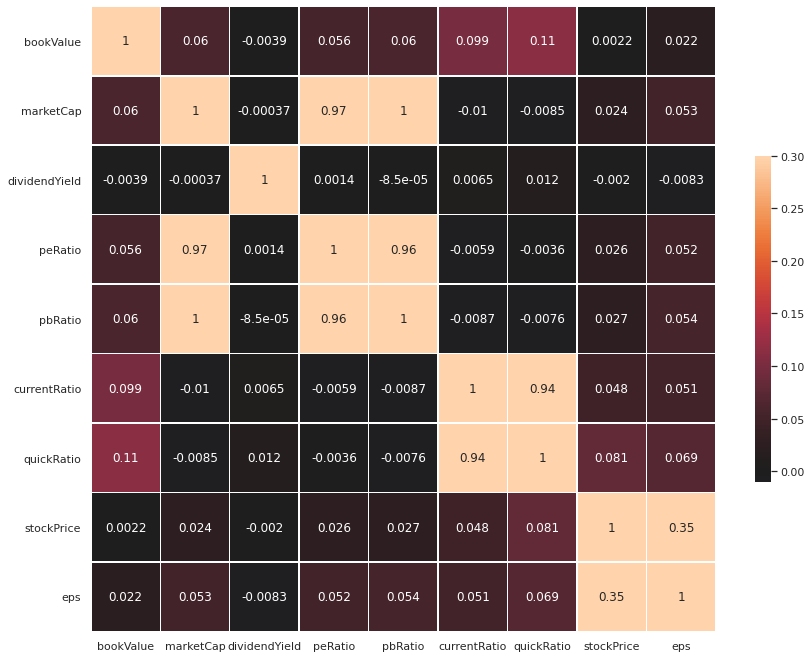

In [ ]:
# Correlation matrix WITHOUT NaN rows

sns.set_theme(style="white")

# Correlation
corr_noNAN = df_test_noNAN.corr()
corr_wNAN = df_test.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_noNAN, annot=True, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

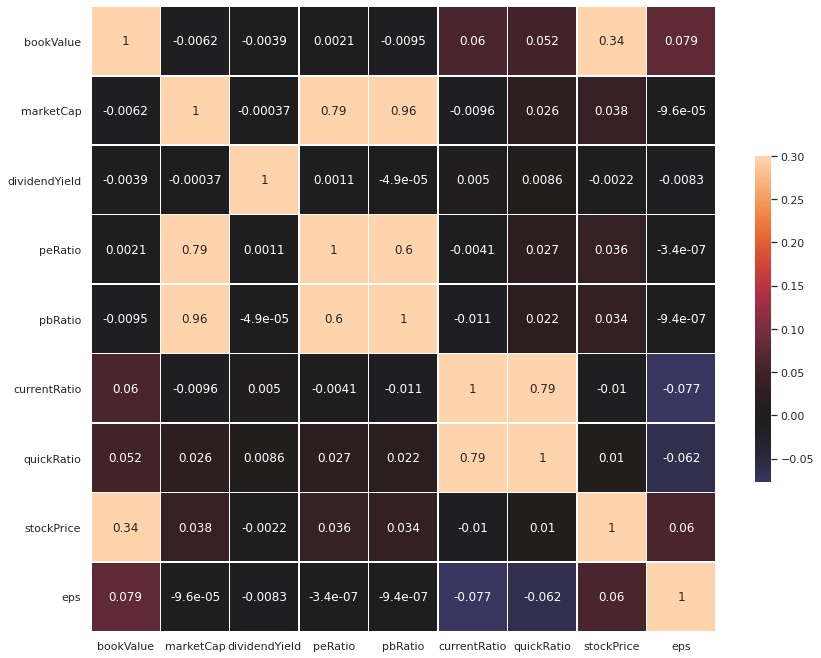

In [ ]:
# WITH NaN rows

f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_wNAN, annot=True, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})